In [ ]:
# We start by getting access to the drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import sys,os
# change directory
%cd '/content/drive/My Drive'
# Let's import the python files to have access to its functions and Classes
path_to_module='/content/drive/My Drive/Training CNN Model/'
sys.path.append(os.path.abspath(path_to_module))
import class_utils, class_model, class_datasets

/content/drive/My Drive


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

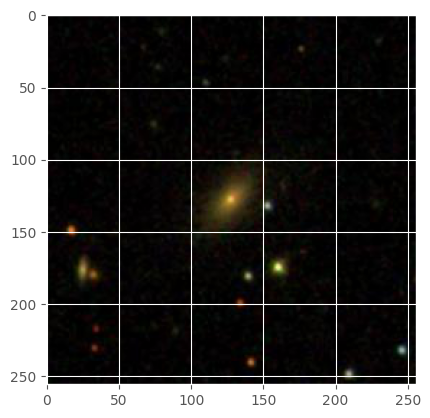

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

img = get_image('/content/drive/My Drive/DATASET/test/elliptical/Dr7_587725469590749389.jpg')
plt.imshow(img)

In [ ]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [ ]:
# Image size
IMG_SIZE = (256, 256)

# Template size
TEMPLATE_SIZE = 256

# Number of epochs
EPOCHS = 25

# Batch size
BATCH_SIZE = 64

# Learning rate
LEARNING_RATE = 0.0005

# Labels of the classes to classify
# labels = ['elliptical', 'spiral', 'uncertain']

# Number of classes to distinguish in the classifier
CLASES = 3

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# initialize the model and load the trained weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights).to(device)

checkpoint = torch.load('/content/drive/My Drive/Training CNN Model/outputs/model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_dataset = torchvision.datasets.ImageFolder(
    root = '/content/drive/My Drive/DATASET/test/',
    transform=test_transform
    )

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
idx2label = test_dataset.classes

In [ ]:
print(idx2label)

['elliptical', 'spiral', 'uncertain']


In [ ]:
# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
import cv2
image_test = '/content/drive/My Drive/DATASET/test/elliptical/Dr7_587725469590749389.jpg'

# read and preprocess the image
image = cv2.imread(image_test)
# get the ground truth class
gt_class = image_test.split('/')[-2]
orig_image = image.copy()
# convert to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transform(image)
# add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image.to(device))
# output_label = torch.topk(outputs, 1)

In [ ]:
probs = F.softmax(outputs, dim=1)
probs3 = probs.topk(3)

print(probs3)

torch.return_types.topk(
values=tensor([[0.7139, 0.2385, 0.0204]], device='cuda:0'),
indices=tensor([[0, 2, 1]], device='cuda:0'))


In [ ]:
def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=7a885e0e51b46749e3c5b47ed7baa4177ce0cc2bd1687a77f62305e39bf090a4
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=255,
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from skimage.segmentation import mark_boundaries

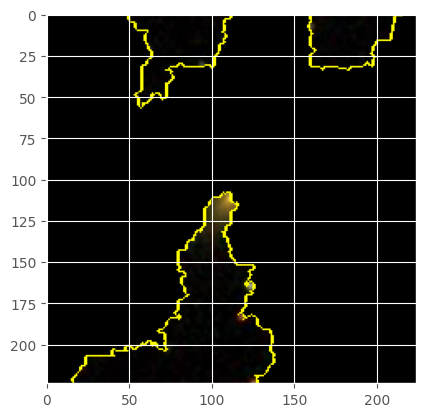

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp/255.0, mask))

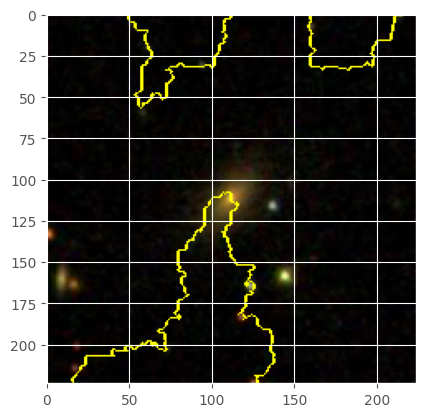

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

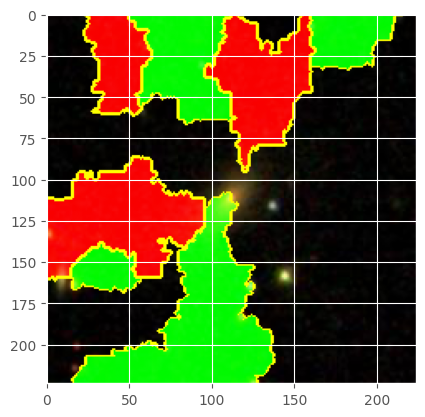

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)

# We can see the 'pros and cons' (pros in green, cons in red)
plt.imshow(img_boundry2)

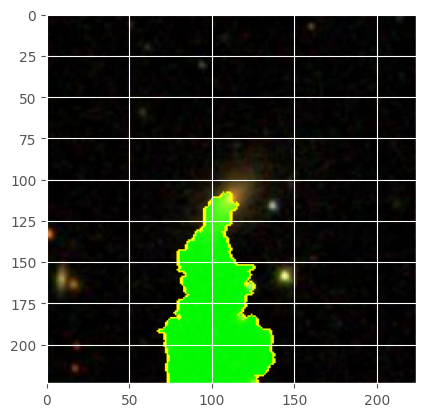

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)

# Or the pros and cons that have weight at least 0.1
plt.imshow(mark_boundaries(temp/255.0, mask))